#### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import xgboost as xgb
import lightgbm as lgb

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import VarianceThreshold

## 1. Load Data

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
combined_data = pd.concat([train_data,test_data],axis=0, ignore_index=True) #combined both train and test data
combined_data['Label'] = combined_data['SalePrice'].isnull() #new column 'label' on basis of 'SalePrice' column values
combined_data['Label'] = combined_data['Label'].map({False:'Train_data', True:'Test_data'})

## 2.Exploratory Data Analysis

#### 2.1 Train Data Exploration

In [4]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train_data.shape

(1460, 81)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
s1 = train_data.dtypes
s1.groupby(s1).count()

int64      35
float64     3
object     43
dtype: int64

In [8]:
#check null values in data
train_data.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
dtype: int64

#### 2.1 Test Data Exploration

In [9]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [10]:
test_data.shape

(1459, 80)

In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [12]:
s2 = test_data.dtypes
s2.groupby(s2).count()

int64      26
float64    11
object     43
dtype: int64

In [13]:
#check null values
test_data.isnull().sum().sort_values(ascending=False).head(34)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageCond        78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
KitchenQual        1
TotalBsmtSF        1
Exterior2nd        1
GarageCars         1
Exterior1st        1
GarageArea         1
SaleType           1
MiscVal            0
dtype: int64

#### 2.3 Train & Test Data comparison

* We noticed that datatypes seems not to match in train data and test data

* Datatype comparison
* Null data comparison
* Distribution comparison

In [14]:
s1_train = s1.drop('SalePrice')
s1_train.compare(s2)

,self,other
BsmtFinSF1,int64,float64
BsmtFinSF2,int64,float64
BsmtUnfSF,int64,float64
TotalBsmtSF,int64,float64
BsmtFullBath,int64,float64
BsmtHalfBath,int64,float64
GarageCars,int64,float64
GarageArea,int64,float64


In [15]:
test_data['GarageArea'].head()

0    730.0
1    312.0
2    482.0
3    470.0
4    506.0
Name: GarageArea, dtype: float64

In [16]:
train_data['GarageArea'].head()

0    548
1    460
2    608
3    642
4    836
Name: GarageArea, dtype: int64

In [17]:
#null value comparison
null_train = train_data.isnull().sum()
null_test = test_data.isnull().sum()
null_train = null_train.drop('SalePrice')
null_train.compare(null_test).sort_values(['self','other'],ascending=[False,False])

,self,other
PoolQC,1453.0,1456.0
MiscFeature,1406.0,1408.0
Alley,1369.0,1352.0
Fence,1179.0,1169.0
FireplaceQu,690.0,730.0
LotFrontage,259.0,227.0
GarageYrBlt,81.0,78.0
GarageFinish,81.0,78.0
GarageQual,81.0,78.0
GarageCond,81.0,78.0


In [18]:
#below features have most missing values so we can drop this features
null_train.compare(null_test).sort_values(['self','other'],ascending=[False,False]).index[0:4]

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], dtype='object')

In [19]:
#Data distribution comparison
con_var = s1[s1.values != 'object'].index

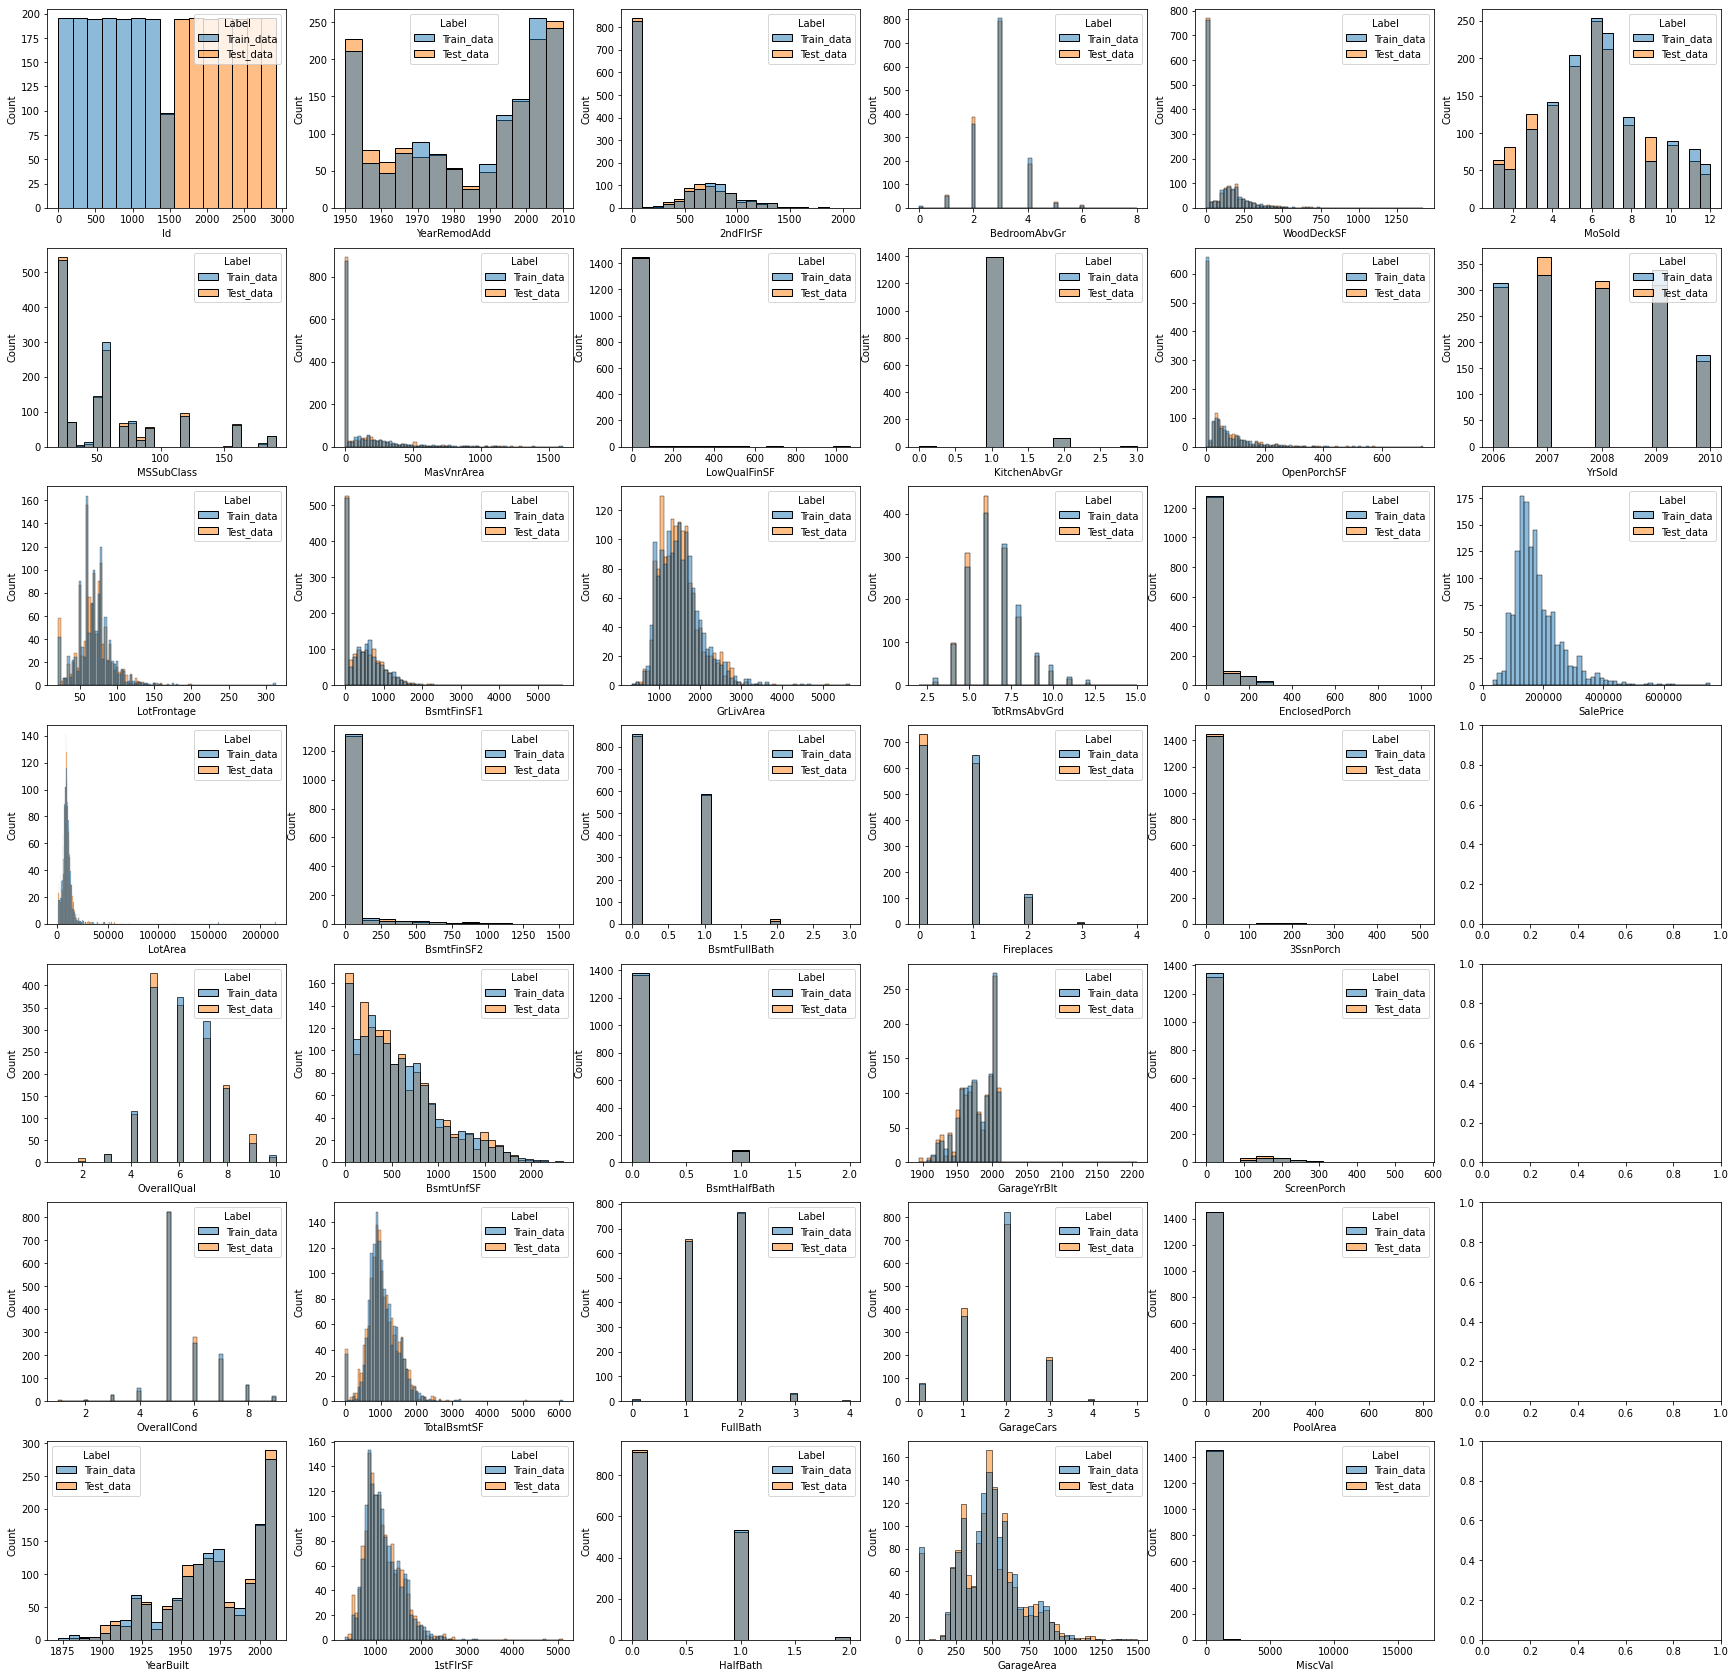

In [26]:
fig, axes = plt.subplots(7,6,figsize=(30,30))
for i, feature in enumerate(con_var):
    sns.histplot(data=combined_data,x=feature,hue='Label',ax=axes[i%7,i//7])

Conclusion:
   * Distrubution for train and test data looks similar for continous features
   * some features can be classified as categorical features
   * some features are dominated by null so can be dropped

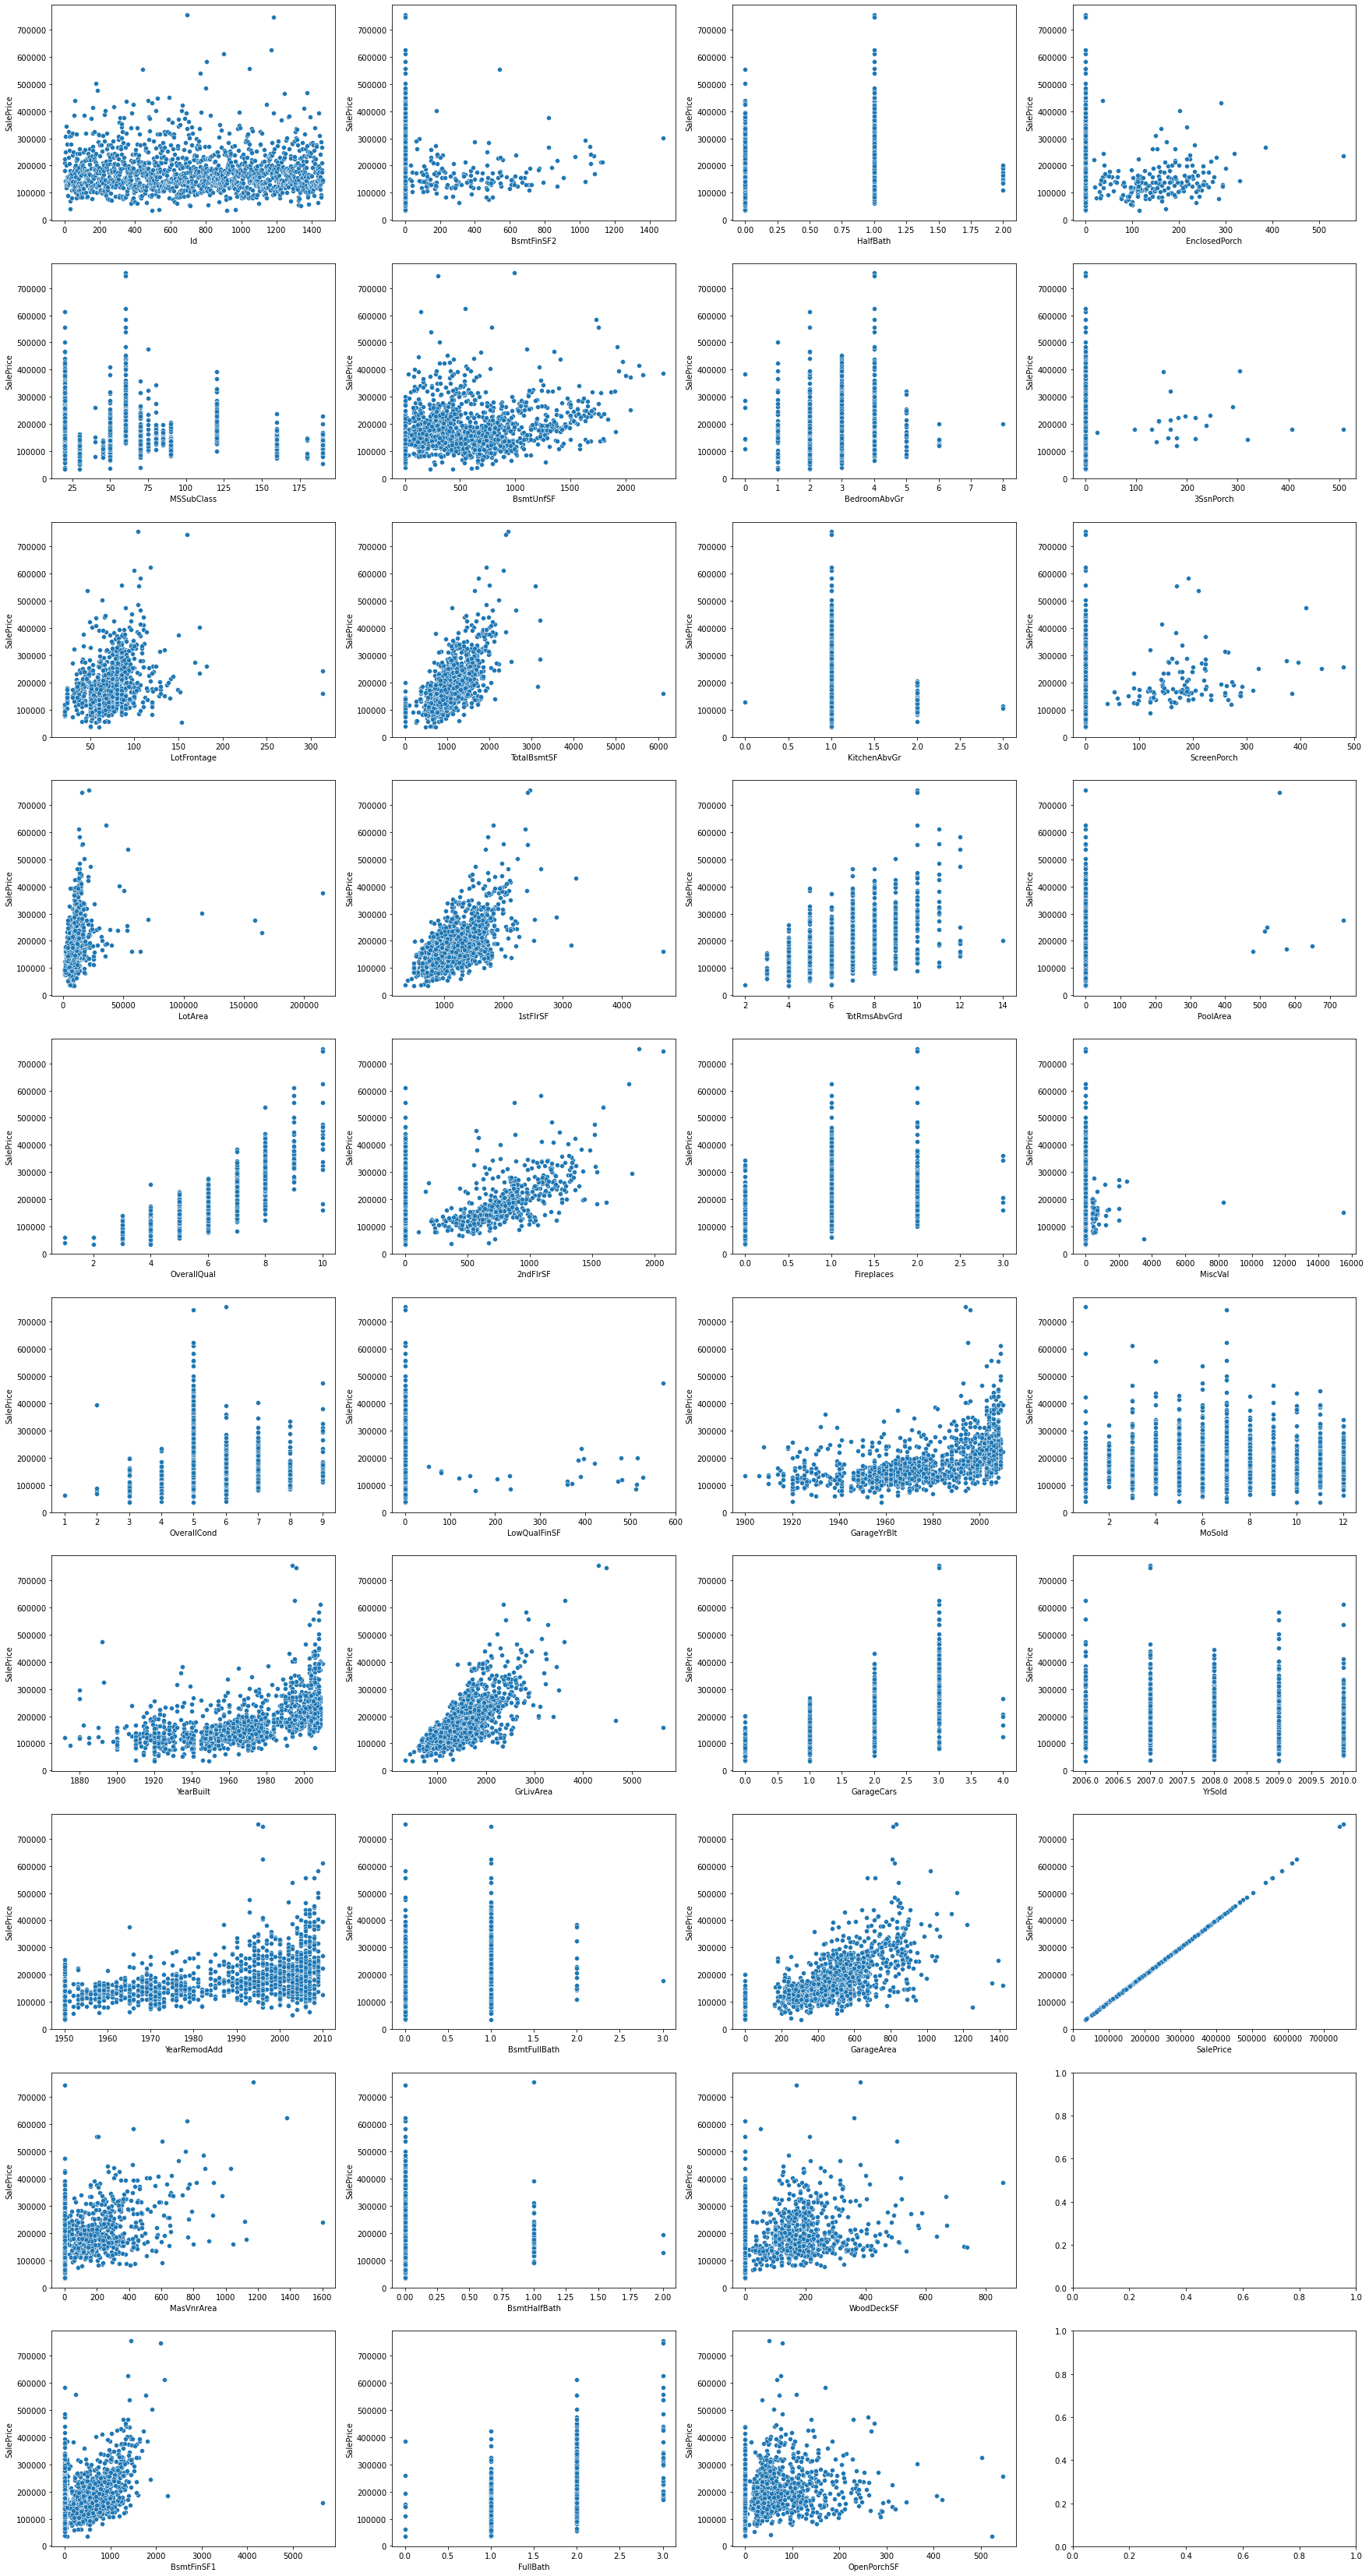

In [32]:
#linearity between features and target feature
fig, ax = plt.subplots(10,4,figsize=(30,60))

for i, feature in enumerate(con_var):
    sns.scatterplot(data=train_data,x=feature,y='SalePrice',ax=ax[i%10,i//10])

Here we can see some correlation are positive but quite linear
 * 'SalePrice' VS.'BsmtUnfSF'
 * 'SalePrice' VS.'LotFrontage'
 * 'SalePrice' VS.'LotArea'
 * 'SalePrice' VS.'1stFlrSF'
 * 'SalePrice' VS.'GrLivArea'
 * 'SalePrice' VS.'TotalBsmtSF'
 * 'SalePrice' VS.'GarageArea'
 
so we wil